$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global obs_para
obs_para=6

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5


global coeff
coeff=[]
for i in range(N+1):
    coeff.append(0.3**(N-i))
print(coeff)

[7.178979876918513e-27, 2.392993292306171e-26, 7.976644307687236e-26, 2.6588814358957456e-25, 8.862938119652485e-25, 2.9543127065508286e-24, 9.847709021836096e-24, 3.2825696739453655e-23, 1.0941898913151219e-22, 3.647299637717073e-22, 1.2157665459056911e-21, 4.05255515301897e-21, 1.3508517176729902e-20, 4.5028390589099675e-20, 1.5009463529699892e-19, 5.003154509899964e-19, 1.6677181699666547e-18, 5.559060566555516e-18, 1.853020188851839e-17, 6.176733962839464e-17, 2.0589113209464878e-16, 6.863037736488292e-16, 2.2876792454960975e-15, 7.625597484986993e-15, 2.5418658283289975e-14, 8.472886094429993e-14, 2.8242953648099974e-13, 9.414317882699991e-13, 3.1381059608999976e-12, 1.0460353202999992e-11, 3.4867844009999975e-11, 1.1622614669999992e-10, 3.8742048899999975e-10, 1.291401629999999e-09, 4.3046720999999976e-09, 1.4348906999999992e-08, 4.782968999999997e-08, 1.5943229999999992e-07, 5.314409999999998e-07, 1.7714699999999993e-06, 5.9048999999999975e-06, 1.9682999999999994e-05, 6.56099999

In [2]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [3]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(100-(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return max(10*num_system-r,0)

def reward_report(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,3*num_system), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [4]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(6)
    else:
        result=[]
        for i in range(6):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,3*num_system), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(6):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,3*num_system), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

history_rt=[[[] for i in range(6)] for j in range(N+1)]
history_sut=[[[] for i in range(6)] for j in range(N+1)]
flags_t=[[True for i in range(6)] for j in range(N+1)]

# Simulation


In [5]:
num_iter=80

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(6)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(6)]
    
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,position,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            #r = reward(observation_new)
            r = reward_raw(position_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = position.reshape(-1,3*num_system)
                history_su_next[u_k] = position_new.reshape(-1,3*num_system)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], position.reshape(-1,3*num_system)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], position_new.reshape(-1,3*num_system)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,position)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            #r = reward(observation_new)
            r = reward_raw(position_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], position.reshape(-1,3*num_system)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], position_new.reshape(-1,3*num_system)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(6):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-10).fit(np.array(history_su[j]).reshape(-1,3*num_system), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(6):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-10).fit(np.array(history_su[j]).reshape(-1,3*num_system), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(6):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-10).fit(np.array(history_su[j]).reshape(-1,3*num_system), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|█                                                                                  | 1/80 [00:00<00:46,  1.68it/s]

observation = [-2.61870015e+00 -3.61498731e+00 -1.41371669e+00  5.36046059e-03
  6.54475933e-03  2.49824361e-03]


  2%|██                                                                                 | 2/80 [00:01<00:51,  1.51it/s]

observation = [-2.31076206e+00 -2.43862238e+00 -7.06858347e-01  1.35824415e-04
  8.84763471e-04  6.24560904e-04]


  4%|███                                                                                | 3/80 [00:02<00:52,  1.47it/s]

observation = [-2.89418061e+00 -3.30387880e+00  2.35619449e-01  1.08538933e-02
  3.28035708e-03  6.93956559e-05]


  5%|████▏                                                                              | 4/80 [00:02<00:51,  1.48it/s]

observation = [-4.27343580e+00 -1.32355095e+00 -2.35619449e-01  3.07288146e-03
  1.22496342e-03  6.93956559e-05]


  6%|█████▏                                                                             | 5/80 [00:03<00:48,  1.56it/s]

observation = [-2.46385758e+00 -1.65642037e+00 -1.80411242e-17  7.65561695e-04
  5.10250105e-04  5.86638261e-33]


  8%|██████▏                                                                            | 6/80 [00:03<00:48,  1.53it/s]

observation = [-1.13919556e+00 -2.24045980e+00 -2.35619449e-01  7.67390986e-04
  2.79744833e-04  6.93956559e-05]


  9%|███████▎                                                                           | 7/80 [00:04<00:49,  1.49it/s]

observation = [-1.51700149e+00 -1.65497747e+00 -2.35619449e-01  8.50968743e-04
  4.26798835e-04  6.93956559e-05]


 10%|████████▎                                                                          | 8/80 [00:05<00:50,  1.43it/s]

observation = [-1.14072201e+00 -2.13128160e+00 -4.71238898e-01  7.61671254e-04
  7.34213764e-05  2.77582624e-04]


 11%|█████████▎                                                                         | 9/80 [00:06<00:51,  1.37it/s]

observation = [-4.89054540e-01 -2.02991748e+00  2.35619449e-01  2.93440046e-03
  3.92241481e-06  6.93956559e-05]


 12%|██████████▎                                                                       | 10/80 [00:07<00:56,  1.25it/s]

observation = [-5.41176649e-01 -1.65950536e+00  7.06858347e-01  2.36961440e-03
  5.68983274e-04  6.24560904e-04]


 14%|███████████▎                                                                      | 11/80 [00:08<01:00,  1.14it/s]

observation = [-5.65620773e-01 -1.65430550e+00  4.71238898e-01  2.12797563e-03
  5.68378773e-04  2.77582624e-04]


 15%|████████████▎                                                                     | 12/80 [00:09<01:04,  1.05it/s]

observation = [-3.94815125e-01 -2.14933746e+00  7.06858347e-01  4.06057264e-03
  7.11399959e-05  6.24560904e-04]


 16%|█████████████▎                                                                    | 13/80 [00:10<01:08,  1.02s/it]

observation = [-4.62204162e-01 -1.82826463e+00  4.71238898e-01  3.22777654e-03
  1.74838152e-04  2.77582624e-04]


 18%|██████████████▎                                                                   | 14/80 [00:11<01:11,  1.09s/it]

observation = [ 1.00400400e+00 -1.08641273e+00 -4.71238898e-01  7.43967749e-03
  3.56984829e-03  2.77582624e-04]


 19%|███████████████▍                                                                  | 15/80 [00:13<01:14,  1.15s/it]

observation = [ 1.06136732e+00 -9.15915461e-01  2.35619449e-01  8.42026430e-03
  5.46994256e-03  6.93956559e-05]


 20%|████████████████▍                                                                 | 16/80 [00:14<01:17,  1.22s/it]

observation = [ 0.76320132 -0.35784472  0.9424778   0.00379341  0.01152294  0.00111033]


 21%|█████████████████▍                                                                | 17/80 [00:15<01:21,  1.30s/it]

observation = [ 0.6931723  -0.29405026  0.9424778   0.00298672  0.01208647  0.00111033]


 22%|██████████████████▍                                                               | 18/80 [00:17<01:26,  1.39s/it]

observation = [ 9.74348072e-01 -5.99345753e-01  4.71238898e-01  6.87368793e-03
  8.83826582e-03  2.77582624e-04]


 24%|███████████████████▍                                                              | 19/80 [00:19<01:31,  1.50s/it]

observation = [ 0.9358188  -0.73480439  1.17809725  0.00618885  0.00713746  0.00173489]


 25%|████████████████████▌                                                             | 20/80 [00:21<01:36,  1.61s/it]

observation = [ 8.09473055e-01 -3.45210177e-01  7.06858347e-01  4.23842028e-03
  1.22955722e-02  6.24560904e-04]


 26%|█████████████████████▌                                                            | 21/80 [00:23<01:41,  1.73s/it]

observation = [6.17523259e-01 3.47545850e-01 1.88495559e+00 2.37883129e-04
 1.71764965e-02 4.44132198e-03]


 28%|██████████████████████▌                                                           | 22/80 [00:25<01:49,  1.89s/it]

observation = [ 1.06147557e+00  1.95459338e-01 -1.80411242e-17  2.90617064e-03
  1.92090031e-02  5.09601063e-33]


 29%|███████████████████████▌                                                          | 23/80 [00:27<01:58,  2.08s/it]

observation = [6.74981259e-01 4.40438594e-01 1.88495559e+00 3.07130318e-04
 2.03797876e-02 4.44132198e-03]


 30%|████████████████████████▌                                                         | 24/80 [00:30<02:06,  2.27s/it]

observation = [1.68405613e-01 4.51552964e-01 1.64933614e+00 4.45685803e-04
 1.37012147e-02 3.40038714e-03]


 31%|█████████████████████████▋                                                        | 25/80 [00:33<02:17,  2.51s/it]

observation = [1.00916015e+00 9.75780057e-01 4.71238898e-01 1.38556298e-04
 3.07739941e-02 2.77582624e-04]


 32%|██████████████████████████▋                                                       | 26/80 [00:36<02:26,  2.72s/it]

observation = [6.58336499e-01 1.25541109e+00 9.42477796e-01 4.44981614e-04
 3.33942888e-02 1.11033050e-03]


 34%|███████████████████████████▋                                                      | 27/80 [00:40<02:34,  2.92s/it]

observation = [ 1.88728694e+00 -6.48557474e-01 -7.06858347e-01  9.19011471e-03
  8.85618232e-03  6.24560904e-04]


 35%|████████████████████████████▋                                                     | 28/80 [00:44<02:45,  3.18s/it]

observation = [0.55627504 1.45147028 1.17809725 0.00268386 0.02572743 0.00173489]


 36%|█████████████████████████████▋                                                    | 29/80 [00:48<02:53,  3.40s/it]

observation = [9.66191356e-01 1.18586359e+00 7.06858347e-01 5.64306356e-05
 3.62216055e-02 6.24560904e-04]


 38%|██████████████████████████████▊                                                   | 30/80 [00:52<03:00,  3.60s/it]

observation = [9.10184936e-01 1.34216526e+00 9.42477796e-01 1.64302691e-05
 4.05677900e-02 1.11033050e-03]


 39%|███████████████████████████████▊                                                  | 31/80 [00:56<03:09,  3.87s/it]

observation = [ 8.84406912e-01  1.06267730e+00 -1.80411242e-17  1.56917030e-05
  3.15668001e-02  5.09601063e-33]


 40%|████████████████████████████████▊                                                 | 32/80 [01:01<03:17,  4.12s/it]

observation = [1.59425413e+00 1.02208022e+00 4.71238898e-01 9.83067096e-04
 3.17205561e-02 2.77582624e-04]


 41%|█████████████████████████████████▊                                                | 33/80 [01:06<03:24,  4.36s/it]

observation = [1.69032783e+00 5.87548783e-01 4.71238898e-01 5.69906346e-03
 2.92178764e-02 2.77582624e-04]


 42%|██████████████████████████████████▊                                               | 34/80 [01:11<03:32,  4.61s/it]

observation = [1.42641403e+00 9.25821071e-01 2.35619449e-01 2.48810481e-03
 3.49792336e-02 6.93956559e-05]


 44%|███████████████████████████████████▉                                              | 35/80 [01:16<03:39,  4.87s/it]

observation = [1.84923280e+00 2.62199231e-01 7.06858347e-01 8.38989167e-03
 2.28229310e-02 6.24560904e-04]


 45%|████████████████████████████████████▉                                             | 36/80 [01:22<03:45,  5.13s/it]

observation = [0.34638658 1.32021992 1.41371669 0.00223293 0.03001567 0.00249824]


 46%|█████████████████████████████████████▉                                            | 37/80 [01:28<03:52,  5.40s/it]

observation = [1.77101495e+00 3.86687017e-01 4.16333634e-18 7.02509255e-03
 2.49701070e-02 1.70637393e-33]


 48%|██████████████████████████████████████▉                                           | 38/80 [01:34<03:58,  5.68s/it]

observation = [3.03648447e-01 1.05638011e-01 1.64933614e+00 2.88667092e-04
 1.61246125e-02 3.40038714e-03]


 49%|███████████████████████████████████████▉                                          | 39/80 [01:41<04:07,  6.04s/it]

observation = [1.55361433e+00 1.15690780e+00 2.35619449e-01 7.15744728e-04
 3.52525690e-02 6.93956559e-05]


 50%|█████████████████████████████████████████                                         | 40/80 [01:48<04:14,  6.37s/it]

observation = [5.37097240e-01 1.34534445e+00 4.71238898e-01 1.11424097e-03
 3.45367927e-02 2.77582624e-04]


 51%|██████████████████████████████████████████                                        | 41/80 [01:56<04:25,  6.80s/it]

observation = [-1.34559375e-03  7.94044022e-01  1.88495559e+00  1.73445816e-03
  1.97192562e-02  4.44132198e-03]


 52%|███████████████████████████████████████████                                       | 42/80 [02:04<04:29,  7.10s/it]

observation = [0.31017589 1.1923667  1.41371669 0.00187681 0.0249036  0.00249824]


 54%|████████████████████████████████████████████                                      | 43/80 [02:12<04:33,  7.39s/it]

observation = [2.14847756e+00 9.14748676e-01 4.71238898e-01 6.86240182e-03
 3.60688463e-02 2.77582624e-04]


 55%|█████████████████████████████████████████████                                     | 44/80 [02:20<04:35,  7.66s/it]

observation = [1.68953217e+00 1.25300492e+00 4.71238898e-01 1.46067053e-03
 4.04806435e-02 2.77582624e-04]


 56%|██████████████████████████████████████████████▏                                   | 45/80 [02:29<04:41,  8.03s/it]

observation = [1.75427649e+00 1.16286267e+00 4.71238898e-01 1.98947969e-03
 3.85490013e-02 2.77582624e-04]


 57%|███████████████████████████████████████████████▏                                  | 46/80 [02:38<04:42,  8.30s/it]

observation = [2.06611111e+00 8.42520810e-01 2.35619449e-01 5.55095269e-03
 3.34994991e-02 6.93956559e-05]


 59%|████████████████████████████████████████████████▏                                 | 47/80 [02:48<04:48,  8.74s/it]

observation = [2.25262317e+00 1.60224909e+00 7.06858347e-01 2.89107134e-03
 5.20295636e-02 6.24560904e-04]


 60%|█████████████████████████████████████████████████▏                                | 48/80 [02:59<05:03,  9.49s/it]

observation = [ 1.63537544e+00 -8.30203560e-01  7.06858347e-01  1.20820064e-02
  6.47466005e-03  6.24560904e-04]


 61%|██████████████████████████████████████████████████▏                               | 49/80 [03:10<05:09,  9.98s/it]

observation = [2.47837616e+00 1.39347805e+00 4.71238898e-01 5.82565785e-03
 4.80463218e-02 2.77582624e-04]


 62%|███████████████████████████████████████████████████▎                              | 50/80 [03:21<05:04, 10.16s/it]

observation = [ 2.53951006e+00  1.17227293e+00 -2.35619449e-01  6.86418204e-03
  4.17136850e-02  6.93956559e-05]


 64%|████████████████████████████████████████████████████▎                             | 51/80 [03:33<05:08, 10.63s/it]

observation = [1.96064801e+00 1.81542745e+00 7.06858347e-01 7.49561936e-04
 5.41033960e-02 6.24560904e-04]


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [03:45<05:08, 11.03s/it]

observation = [7.82271374e-01 1.56153938e+00 7.06858347e-01 1.76460574e-03
 3.43893510e-02 6.24560904e-04]


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [03:59<05:28, 12.15s/it]

observation = [1.93784986e+00 1.77911964e+00 4.71238898e-01 6.45764988e-04
 5.23545982e-02 2.77582624e-04]


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [04:14<05:31, 12.73s/it]

observation = [1.89961625e+00 1.91060083e+00 9.42477796e-01 4.02012938e-04
 5.71878408e-02 1.11033050e-03]


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [04:28<05:34, 13.40s/it]

observation = [1.99689739e+00 2.43637981e+00 9.42477796e-01 6.43676477e-05
 6.71537219e-02 1.11033050e-03]


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [04:42<05:22, 13.45s/it]

observation = [2.37731021e+00 2.29984231e+00 9.42477796e-01 8.12159147e-04
 7.04010169e-02 1.11033050e-03]


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [04:57<05:16, 13.76s/it]

observation = [2.59999645e+00 2.26161513e+00 9.42477796e-01 2.42084553e-03
 7.33220155e-02 1.11033050e-03]


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [05:13<05:19, 14.50s/it]

observation = [3.01416751e+00 1.57069359e+00 2.35619449e-01 8.34998015e-03
 5.27329020e-02 6.93956559e-05]


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [05:29<05:12, 14.89s/it]

observation = [2.38660213e+00 2.17353841e+00 1.17809725e+00 8.58546498e-04
 6.55446707e-02 1.73489140e-03]


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [05:45<05:05, 15.27s/it]

observation = [2.40123609e+00 1.54717905e+00 2.35619449e-01 4.71383722e-03
 5.21077532e-02 6.93956559e-05]


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [06:01<04:56, 15.61s/it]

observation = [2.14761156e+00 3.11239487e+00 7.06858347e-01 8.37509917e-04
 8.70288715e-02 6.24560904e-04]


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [06:18<04:48, 16.02s/it]

observation = [2.54442744e+00 1.30933279e+00 4.71238898e-01 6.67069768e-03
 4.67317493e-02 2.77582624e-04]


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [06:37<04:46, 16.82s/it]

observation = [2.74933538e+00 1.93864811e+00 4.71238898e-01 4.18393962e-03
 6.25716626e-02 2.77582624e-04]


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [06:56<04:38, 17.41s/it]

observation = [2.12990407e+00 2.27674633e+00 1.17809725e+00 8.71000956e-05
 6.31318037e-02 1.73489140e-03]


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [07:15<04:29, 17.99s/it]

observation = [3.05440067e+00 1.65713821e+00 1.17809725e+00 8.84115632e-03
 5.72999956e-02 1.73489140e-03]


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [07:35<04:18, 18.47s/it]

observation = [2.83553047e+00 1.87085113e+00 4.16333634e-18 5.30115808e-03
 6.16596870e-02 1.70637393e-33]


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [07:54<04:03, 18.72s/it]

observation = [2.31166484e+00 2.23119171e+00 1.17809725e+00 6.18878491e-04
 6.51025106e-02 1.73489140e-03]


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [08:14<03:48, 19.06s/it]

observation = [3.09110317e+00 2.08528375e+00 7.06858347e-01 3.73115057e-03
 6.38794179e-02 6.24560904e-04]


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [08:34<03:35, 19.59s/it]

observation = [2.91730087e+00 1.74887019e+00 4.16333634e-18 6.56603135e-03
 5.83217402e-02 1.70637393e-33]


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [08:56<03:21, 20.14s/it]

observation = [2.78372957e+00 1.86079240e+00 4.71238898e-01 4.69996666e-03
 5.99064269e-02 2.77582624e-04]


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [09:18<03:06, 20.67s/it]

observation = [3.14608249e+00 2.33638520e+00 9.42477796e-01 4.30713991e-03
 7.48682306e-02 1.11033050e-03]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [09:40<02:49, 21.17s/it]

observation = [2.88910596e+00 1.79069846e+00 1.41371669e+00 5.90241274e-03
 5.98502767e-02 2.49824361e-03]


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [10:05<02:36, 22.32s/it]

observation = [2.93260872e+00 1.77772524e+00 9.42477796e-01 6.75633580e-03
 5.97403577e-02 1.11033050e-03]


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [10:32<02:22, 23.80s/it]

observation = [2.75329357e+00 2.00985774e+00 4.16333634e-18 4.16298904e-03
 6.58111941e-02 1.70637393e-33]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [10:57<02:00, 24.04s/it]

observation = [ 3.23364939e+00  1.91717470e+00 -2.63677968e-17  5.47736373e-03
  6.20524143e-02  6.26697604e-33]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [11:22<01:37, 24.28s/it]

observation = [2.89592356e+00 1.74104303e+00 4.16333634e-18 6.25934431e-03
 5.75915981e-02 1.70637393e-33]


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [11:48<01:14, 24.83s/it]

observation = [2.99406616e+00 2.47932466e+00 2.35619449e-01 2.65218167e-03
 7.76249518e-02 6.93956559e-05]


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [12:15<00:50, 25.46s/it]

observation = [2.74682736e+00 2.06511371e+00 2.35619449e-01 4.08377749e-03
 6.76536213e-02 6.93956559e-05]


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [12:46<00:27, 27.06s/it]

observation = [3.06916074e+00 2.30845885e+00 7.06858347e-01 3.41356448e-03
 7.21586530e-02 6.24560904e-04]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [13:15<00:00,  9.94s/it]

observation = [3.05944863e+00 1.22889856e+00 1.41371669e+00 1.52826760e-02
 5.52929483e-02 2.49824361e-03]


# Results

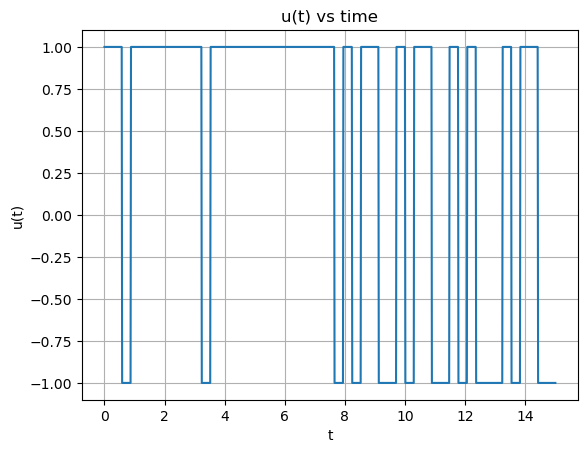

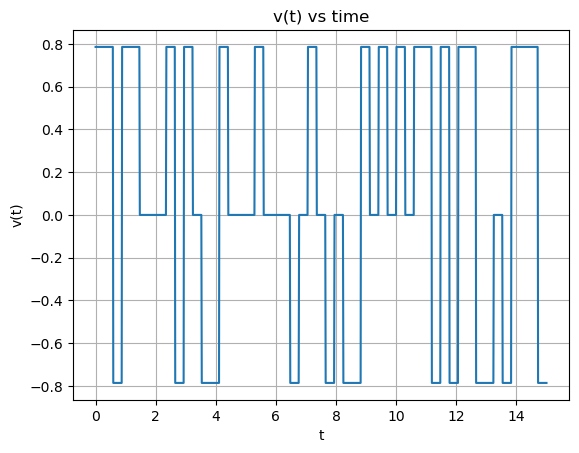

In [6]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


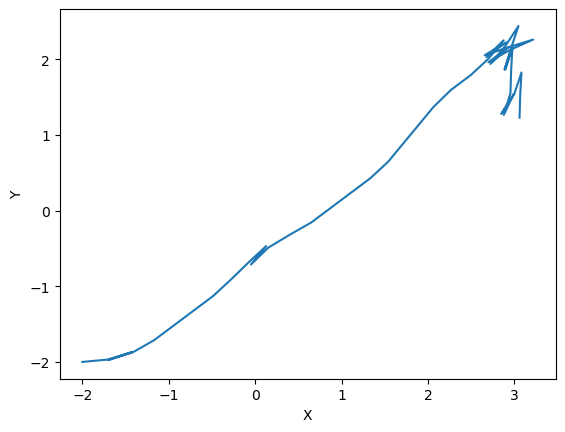

In [7]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

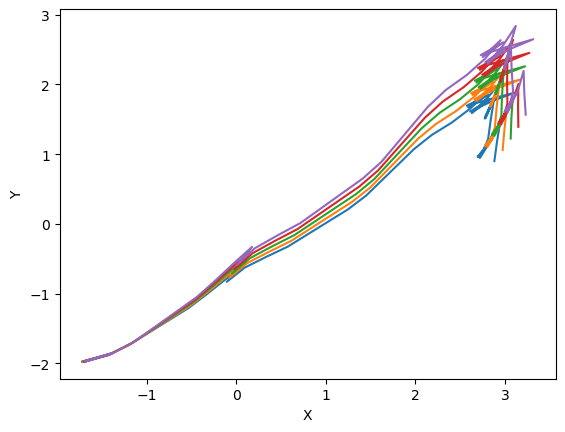

46.05977356987289


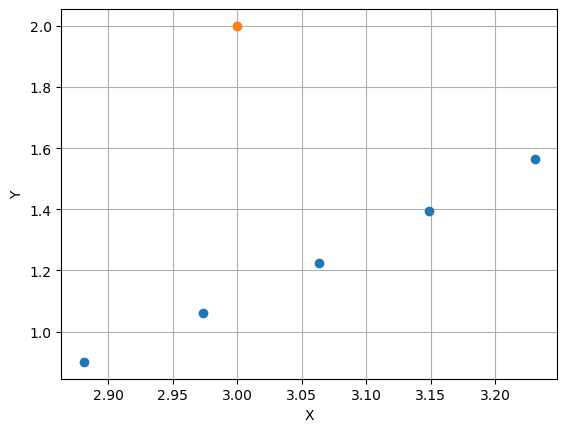

In [8]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

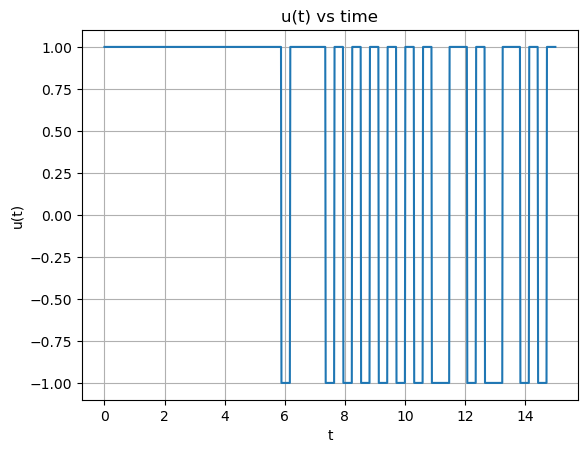

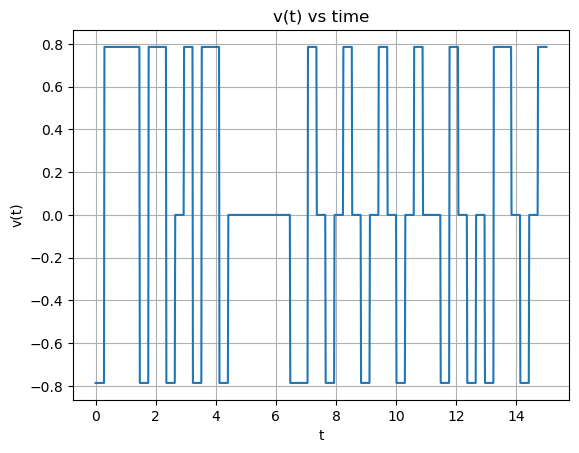

In [9]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

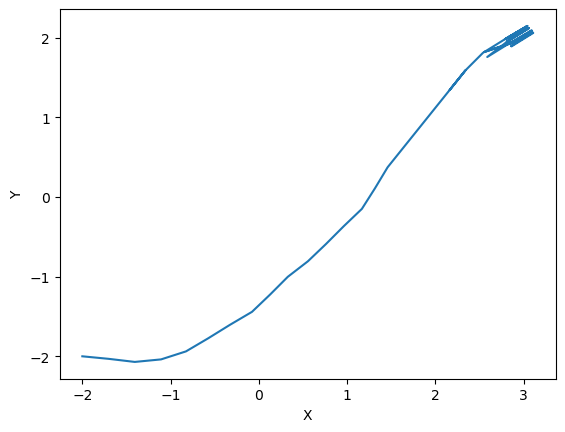

In [10]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

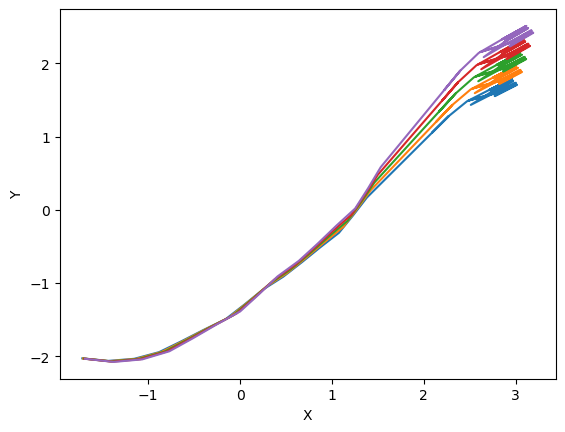

48.72163569623016


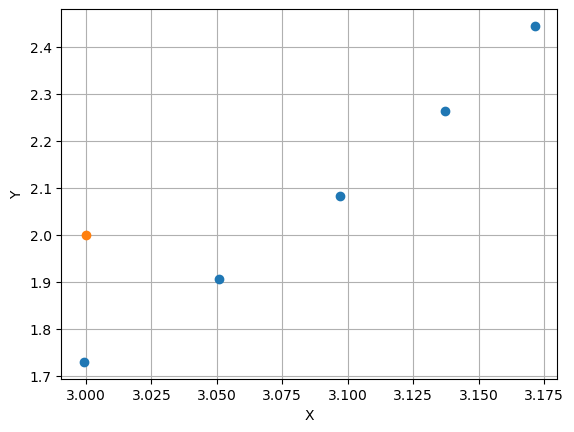

In [11]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

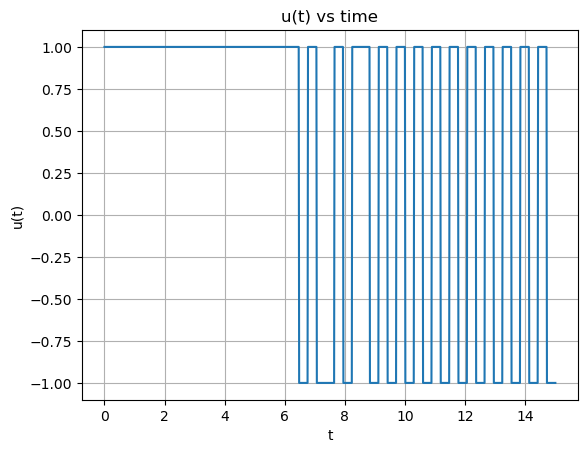

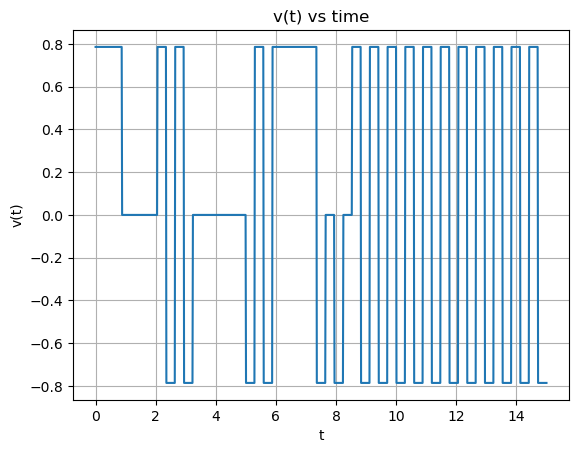

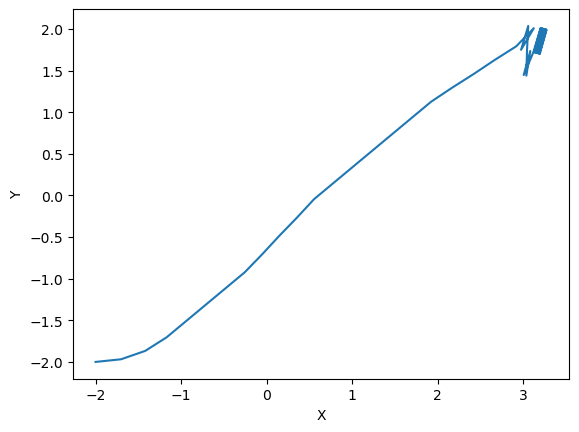

In [12]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,position)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

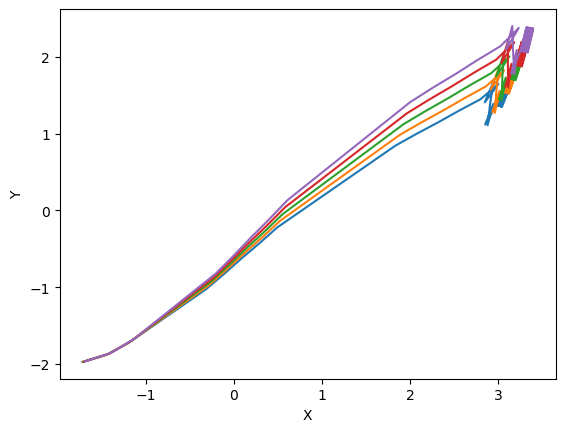

2.1353756936427093


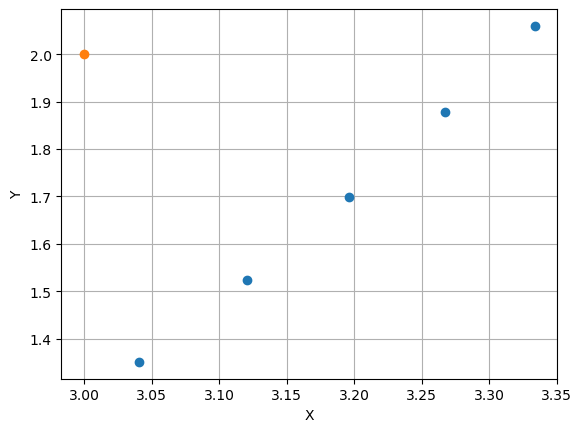

In [13]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_report(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()